# Backtest of the Intraday TQQQ Strategy
The Strategy works as follows:
1. Before market open, calculate the Average True Range (ATR) of TQQQ over the last 14 days. 
Use 7.5% of this number as your stop width.
2. Wait for the first 5 minutes of price action. (09:30-09:34 EST). If the move from market open 
is positive, go long. If it's negative, go short.
3. Place your stop at 7.5% ATR away from the 5-minute close.
4. If your stop isn't hit, close the position at the end of the trading session (16:00 EST).

## Imports, Setup, and and Data Fetching

In [178]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from typing import Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns
from polygon import RESTClient
from config import settings
from tqdm.notebook import tqdm
from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')

# Set some pandas display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Initialize Polygon client
client = RESTClient(api_key=settings.POLYGON.API_KEY)

In [179]:
def get_cache_dir() -> Path:
    """Create and return the cache directory path"""
    cache_dir = Path("data_cache")
    cache_dir.mkdir(exist_ok=True)
    return cache_dir

def get_cache_filename(symbol: str, timeframe: str, start_date: str, end_date: str) -> str:
    """Generate a consistent cache filename based on parameters"""
    return f"{symbol}_{timeframe}_{start_date}_{end_date}.csv"

def get_historical_data(symbol: str, start_date: str, end_date: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Get both 1-minute and 5-minute historical data from Polygon with caching"""
    cache_dir = get_cache_dir()
    
    # Cache filenames for both timeframes
    cache_1min = cache_dir / get_cache_filename(symbol, "1min", start_date, end_date)
    cache_5min = cache_dir / get_cache_filename(symbol, "5min", start_date, end_date)
    
    if cache_1min.exists() and cache_5min.exists():
        print("Loading cached data...")
        # Load with proper parsing of timezone-aware timestamps
        df_1min = pd.read_csv(cache_1min, parse_dates=['timestamp'])
        df_5min = pd.read_csv(cache_5min, parse_dates=['timestamp'])
        
        # Set index without timezone conversion
        df_1min.set_index('timestamp', inplace=True)
        df_5min.set_index('timestamp', inplace=True)
        
        return df_1min, df_5min
    
    print("Fetching historical data from Polygon...")
    
    # Get 1-minute data for opening 5 minutes
    aggs_1min = []
    for a in tqdm(client.list_aggs(
        ticker=symbol,
        multiplier=1,
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    ), desc="1-min data"):
        dt = pd.Timestamp(a.timestamp, unit='ms', tz='UTC')
        if dt.hour == 9 and 30 <= dt.minute <= 34:
            aggs_1min.append({
                'timestamp': a.timestamp,
                'Open': a.open,
                'High': a.high,
                'Low': a.low,
                'Close': a.close,
                'Volume': a.volume
            })
    
    # Get 5-minute data for the rest of the day
    aggs_5min = []
    for a in tqdm(client.list_aggs(
        ticker=symbol,
        multiplier=5,
        timespan="minute",
        from_=start_date,
        to=end_date,
        limit=50000
    ), desc="5-min data"):
        dt = pd.Timestamp(a.timestamp, unit='ms', tz='UTC')
        if dt.hour > 9 or (dt.hour == 9 and dt.minute >= 35):
            aggs_5min.append({
                'timestamp': a.timestamp,
                'Open': a.open,
                'High': a.high,
                'Low': a.low,
                'Close': a.close,
                'Volume': a.volume
            })
    
    # Convert to DataFrames
    df_1min = pd.DataFrame(aggs_1min)
    df_5min = pd.DataFrame(aggs_5min)
    
    # Cache the data
    df_1min.to_csv(cache_1min)
    df_5min.to_csv(cache_5min)
    
    return df_1min, df_5min

In [180]:
def get_daily_data(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
    """Get daily data from Polygon with caching"""
    cache_dir = get_cache_dir()
    cache_file = cache_dir / get_cache_filename(symbol, "daily", start_date, end_date)
    
    # Check if cached data exists and is fresh (less than 1 day old)
    if cache_file.exists():
        cache_age = (pd.Timestamp.now() - pd.Timestamp.fromtimestamp(cache_file.stat().st_mtime)).days
        if cache_age < 1:
            print("Loading cached daily data...")
            df = pd.read_csv(cache_file, index_col='timestamp', parse_dates=True)
            return df
    
    print("Fetching daily data from Polygon...")
    aggs = []
    for a in tqdm(client.list_aggs(
        ticker=symbol,
        multiplier=1,
        timespan="day",
        from_=start_date,
        to=end_date,
        limit=50000
    ), desc="Daily data"):
        aggs.append({
            'timestamp': a.timestamp,
            'Open': a.open,
            'High': a.high,
            'Low': a.low,
            'Close': a.close,
            'Volume': a.volume
        })
    
    df = pd.DataFrame(aggs)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # Cache the data
    df.to_csv(cache_file)
    
    return df

def calculate_atr(daily_data: pd.DataFrame, lookback: int = 14) -> float:
    """Calculate ATR based on daily data"""
    # Calculate True Range
    daily_data = daily_data.copy()
    daily_data['High-Low'] = daily_data['High'] - daily_data['Low']
    daily_data['High-PrevClose'] = abs(daily_data['High'] - daily_data['Close'].shift(1))
    daily_data['Low-PrevClose'] = abs(daily_data['Low'] - daily_data['Close'].shift(1))
    daily_data['TR'] = daily_data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    
    # Calculate ATR
    daily_data['ATR'] = daily_data['TR'].rolling(window=lookback).mean()
    
    return daily_data['ATR'].iloc[-1]

In [181]:
def generate_signals(df_1min: pd.DataFrame, min_move_atr_multiple: float = 0.1, atr: float = None) -> pd.DataFrame:
    """Generate trading signals based on first 5 minutes of market data"""
    df = df_1min.copy()
    df['Signal'] = 0
    df['Entry_Price'] = np.nan
    
    # Market open is 9:30 AM ET
    market_open_mask = (df.index.hour == 9) & (df.index.minute == 30)
    if not any(market_open_mask):
        return df
        
    # Get the market open price
    market_open_price = df[market_open_mask]['Open'].iloc[0]
    
    # Get the 9:34 price
    five_min_mask = (df.index.hour == 9) & (df.index.minute == 34)
    if not any(five_min_mask):
        return df
        
    five_min_close = df[five_min_mask]['Close'].iloc[0]
    
    # Calculate the move
    price_move = five_min_close - market_open_price
    
    # Generate signal based on the move
    if price_move > 0:  # Long signal
        df.loc[df[five_min_mask].index[0], 'Signal'] = 1
        df.loc[df[five_min_mask].index[0], 'Entry_Price'] = five_min_close
    elif price_move < 0:  # Short signal
        df.loc[df[five_min_mask].index[0], 'Signal'] = -1
        df.loc[df[five_min_mask].index[0], 'Entry_Price'] = five_min_close
    
    return df

In [182]:
def backtest_strategy(symbol: str, start_date: str, end_date: str, 
                     initial_capital: float,
                     stop_atr_multiple: float,
                     min_move_atr_multiple: float,
                     position_size_risk_pct: float,
                     transaction_cost_pct: float) -> pd.DataFrame:
    """Run backtest of the strategy"""
    df_1min, df_5min = get_historical_data(symbol, start_date, end_date)
    
    print("Calculating ATR...")
    extended_start = pd.Timestamp(start_date) - pd.Timedelta(days=30)
    df_daily = get_daily_data(symbol, extended_start.strftime('%Y-%m-%d'), end_date)
    
    results = []
    current_capital = initial_capital
    
    # Make indices timezone-aware
    df_1min.index = pd.to_datetime(df_1min.index, utc=True)
    df_5min.index = pd.to_datetime(df_5min.index, utc=True)
    
    unique_dates = sorted(set(idx.date() for idx in df_1min.index))
    print(f"Found {len(unique_dates)} trading days to process")
    
    for day in tqdm(unique_dates, desc="Backtest progress"):
        try:
            # Calculate ATR
            current_date = pd.Timestamp(day)
            prev_days = df_daily[df_daily.index < current_date].tail(14)
            if len(prev_days) < 14:
                continue
            
            atr = calculate_atr(prev_days)
            stop_width = atr * stop_atr_multiple  # Using 7.5% of ATR as per strategy
            
            # Get day's data
            day_start = pd.Timestamp(day).replace(hour=0, minute=0)
            day_end = (day_start + pd.Timedelta(days=1))
            
            day_1min = df_1min[(df_1min.index >= pd.Timestamp(day_start, tz=df_1min.index[0].tz)) & 
                              (df_1min.index < pd.Timestamp(day_end, tz=df_1min.index[0].tz))]
            day_5min = df_5min[(df_5min.index >= pd.Timestamp(day_start, tz=df_5min.index[0].tz)) & 
                              (df_5min.index < pd.Timestamp(day_end, tz=df_5min.index[0].tz))]
            
            if len(day_1min) == 0 or len(day_5min) == 0:
                continue
            
            # Generate signals
            signals = generate_signals(day_1min, min_move_atr_multiple, atr)
            entry_signals = signals[signals['Signal'] != 0]
            
            if len(entry_signals) == 0:
                continue
            
            # Get trade details
            entry_time = entry_signals.index[0]
            entry_price = entry_signals['Entry_Price'].iloc[0]
            trade_direction = entry_signals['Signal'].iloc[0]
            
            # Calculate stop price - 7.5% ATR away from entry as per strategy
            stop_price = entry_price - (stop_width * trade_direction)
            
            # Calculate position size based on risk
            risk_amount = current_capital * position_size_risk_pct
            position_size = risk_amount / abs(entry_price - stop_price)
            trade_value = position_size * entry_price
            
            # Apply entry transaction cost
            current_capital -= trade_value * transaction_cost_pct
            
            # Track trade through the day using 5-min data
            day_data_after_entry = day_5min[day_5min.index > entry_time]
            
            if len(day_data_after_entry) == 0:
                continue
                
            # Check for stop hit
            stop_hit = False
            exit_price = day_data_after_entry['Close'].iloc[-1]  # Default to close at 4 PM
            
            for idx, row in day_data_after_entry.iterrows():
                # Check if it's 4 PM
                if idx.hour == 16 and idx.minute == 0:
                    break
                    
                if trade_direction == 1 and row['Low'] <= stop_price:
                    stop_hit = True
                    exit_price = max(row['Open'], stop_price)  # Realistic fill
                    break
                elif trade_direction == -1 and row['High'] >= stop_price:
                    stop_hit = True
                    exit_price = min(row['Open'], stop_price)  # Realistic fill
                    break
            
            # Calculate P&L
            exit_value = position_size * exit_price
            transaction_costs = (trade_value + exit_value) * transaction_cost_pct
            
            if trade_direction == 1:
                pnl = (exit_price - entry_price) * position_size - transaction_costs
            else:
                pnl = (entry_price - exit_price) * position_size - transaction_costs
            
            ret = pnl / trade_value
            current_capital += pnl
            
            results.append({
                'Date': day,
                'Direction': trade_direction,
                'Entry_Time': entry_time,
                'Entry_Price': entry_price,
                'Stop_Price': stop_price,
                'Exit_Price': exit_price,
                'Position_Size': position_size,
                'Stop_Hit': stop_hit,
                'ATR': atr,
                'Stop_Width': stop_width,
                'PnL': pnl,
                'Return': ret,
                'Capital': current_capital
            })
            
        except Exception as e:
            print(f"Error on {day}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        results_df.set_index('Date', inplace=True)
        print(f"Successfully processed {len(results_df)} trades")
    else:
        print("No trades were generated during the backtest period")
    
    return results_df

In [183]:
def analyze_results(results: pd.DataFrame, initial_capital: float = 100000.0) -> None:
    """Analyze and display backtest results with comprehensive performance metrics"""
    if len(results) == 0:
        print("No trades were executed in the backtest period")
        return
    
    # Ensure index is datetime
    if not isinstance(results.index, pd.DatetimeIndex):
        results.index = pd.to_datetime(results.index)
    
    # Calculate returns and cumulative performance
    results['Cumulative_Return'] = (1 + results['Return']).cumprod()
    results['Equity_Curve'] = initial_capital * results['Cumulative_Return']
    results['Drawdown'] = results['Equity_Curve'].div(results['Equity_Curve'].cummax()) - 1
    
    # Calculate trade value for each trade
    results['Trade_Value'] = results['Position_Size'] * results['Entry_Price']
    
    # Basic Trade Statistics
    total_trades = len(results)
    winning_trades = len(results[results['PnL'] > 0])
    losing_trades = len(results[results['PnL'] <= 0])
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Calculate average trade size for scaling
    avg_trade_value = results['Trade_Value'].mean()
    
    # Profit Metrics using normalized PnL values
    avg_win = results[results['PnL'] > 0]['PnL'].mean()
    avg_loss = results[results['PnL'] <= 0]['PnL'].mean()
    max_win = results['PnL'].max()
    max_loss = results['PnL'].min()
    
    # Calculate R-multiples (PnL relative to initial risk)
    risk_per_trade = initial_capital * 0.02  # 2% risk per trade
    results['R_Multiple'] = results['PnL'] / risk_per_trade
    avg_r_win = results[results['PnL'] > 0]['R_Multiple'].mean()
    avg_r_loss = results[results['PnL'] <= 0]['R_Multiple'].mean()
    max_r_win = results['R_Multiple'].max()
    max_r_loss = results['R_Multiple'].min()
    
    profit_factor = abs(results[results['PnL'] > 0]['PnL'].sum() / 
                       results[results['PnL'] < 0]['PnL'].sum()) if losing_trades > 0 else float('inf')
    
    # Portfolio Performance
    final_capital = results['Equity_Curve'].iloc[-1]
    total_return = (final_capital - initial_capital) / initial_capital
    
    # Risk Metrics
    max_drawdown = results['Drawdown'].min() * 100
    avg_drawdown = results['Drawdown'].mean() * 100
    
    # Calculate daily returns for ratios
    daily_returns = results['Return'].resample('D').sum().fillna(0)
    excess_returns = daily_returns - 0.02/252  # Assuming 2% risk-free rate
    
    # Risk Ratios
    annualized_return = ((1 + total_return) ** (252/len(daily_returns)) - 1) * 100
    annualized_volatility = daily_returns.std() * np.sqrt(252) * 100
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / daily_returns.std() if daily_returns.std() != 0 else 0
    sortino_ratio = np.sqrt(252) * excess_returns.mean() / daily_returns[daily_returns < 0].std() if len(daily_returns[daily_returns < 0]) > 0 else 0
    calmar_ratio = -annualized_return / max_drawdown if max_drawdown != 0 else 0
    
    # Risk of Ruin
    consecutive_losses = 0
    max_consecutive_losses = 0
    for pnl in results['PnL']:
        if pnl < 0:
            consecutive_losses += 1
            max_consecutive_losses = max(max_consecutive_losses, consecutive_losses)
        else:
            consecutive_losses = 0
    
    # Print comprehensive results
    print(f"\n{'='*50}")
    print(f"Strategy Performance Analysis")
    print(f"{'='*50}")
    print(f"\nBacktest Period: {results.index[0].strftime('%Y-%m-%d')} to {results.index[-1].strftime('%Y-%m-%d')}")
    
    print(f"\n{'Trade Statistics':=^40}")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Average Trade Value: ${avg_trade_value:.2f}")
    print(f"Average Win: ${avg_win:.2f} ({avg_r_win:.2f}R)")
    print(f"Average Loss: ${avg_loss:.2f} ({avg_r_loss:.2f}R)")
    print(f"Largest Win: ${max_win:.2f} ({max_r_win:.2f}R)")
    print(f"Largest Loss: ${max_loss:.2f} ({max_r_loss:.2f}R)")
    print(f"Max Consecutive Losses: {max_consecutive_losses}")
    
    print(f"\n{'Portfolio Performance':=^40}")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility:.2f}%")
    
    print(f"\n{'Risk Metrics':=^40}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Average Drawdown: {avg_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))
    
    # Equity Curve with Drawdown
    ax1 = axes[0]
    ax1.plot(results.index, results['Equity_Curve'], label='Equity Curve', color='blue')
    ax1.set_title('Equity Curve')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(True)
    
    # Drawdown plot on twin axis
    ax1_dd = ax1.twinx()
    ax1_dd.fill_between(results.index, 0, results['Drawdown'] * 100, color='red', alpha=0.3, label='Drawdown %')
    ax1_dd.set_ylabel('Drawdown %')
    
    # Monthly returns
    monthly_returns = results['Return'].resample('M').sum()
    monthly_returns.plot(kind='bar', ax=axes[1], color=np.where(monthly_returns >= 0, 'green', 'red'))
    axes[1].set_title('Monthly Returns')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Return')
    axes[1].grid(True)
    
    # Distribution of returns
    results['Return'].hist(bins=50, ax=axes[2], density=True, alpha=0.75)
    results['Return'].plot(kind='kde', ax=axes[2], color='red')
    axes[2].set_title('Distribution of Returns')
    axes[2].set_xlabel('Return')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Additional rolling metrics plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Rolling Sharpe Ratio (252-day)
    rolling_sharpe = np.sqrt(252) * results['Return'].rolling(252).mean() / results['Return'].rolling(252).std()
    rolling_sharpe.plot(ax=axes[0])
    axes[0].set_title('Rolling 252-day Sharpe Ratio')
    axes[0].grid(True)
    
    # Rolling 63-day (quarter) Win Rate
    rolling_winrate = results['PnL'].rolling(63).apply(lambda x: np.sum(x > 0) / len(x))
    rolling_winrate.plot(ax=axes[1])
    axes[1].set_title('Rolling 63-day Win Rate')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Loading cached data...
Calculating ATR...
Loading cached daily data...
Found 1242 trading days to process


Backtest progress:   0%|          | 0/1242 [00:00<?, ?it/s]

Successfully processed 772 trades

Strategy Performance Analysis

Backtest Period: 2020-01-03 to 2025-02-26

============Trade Statistics============
Total Trades: 772
Win Rate: 41.71%
Profit Factor: 1.03
Average Trade Value: $52099473.35
Average Win: $599650.39 (299.83R)
Average Loss: $-416925.66 (-208.46R)
Largest Win: $39309107.39 (19654.55R)
Largest Loss: $-18246750.63 (-9123.38R)
Max Consecutive Losses: 11

=========Portfolio Performance==========
Initial Capital: $100,000.00
Final Capital: $244,052.87
Total Return: 144.05%
Annualized Return: 12.69%
Annualized Volatility: 15.99%

==============Risk Metrics==============
Maximum Drawdown: -19.67%
Average Drawdown: -5.64%
Sharpe Ratio: 0.70
Sortino Ratio: 1.00
Calmar Ratio: 0.65


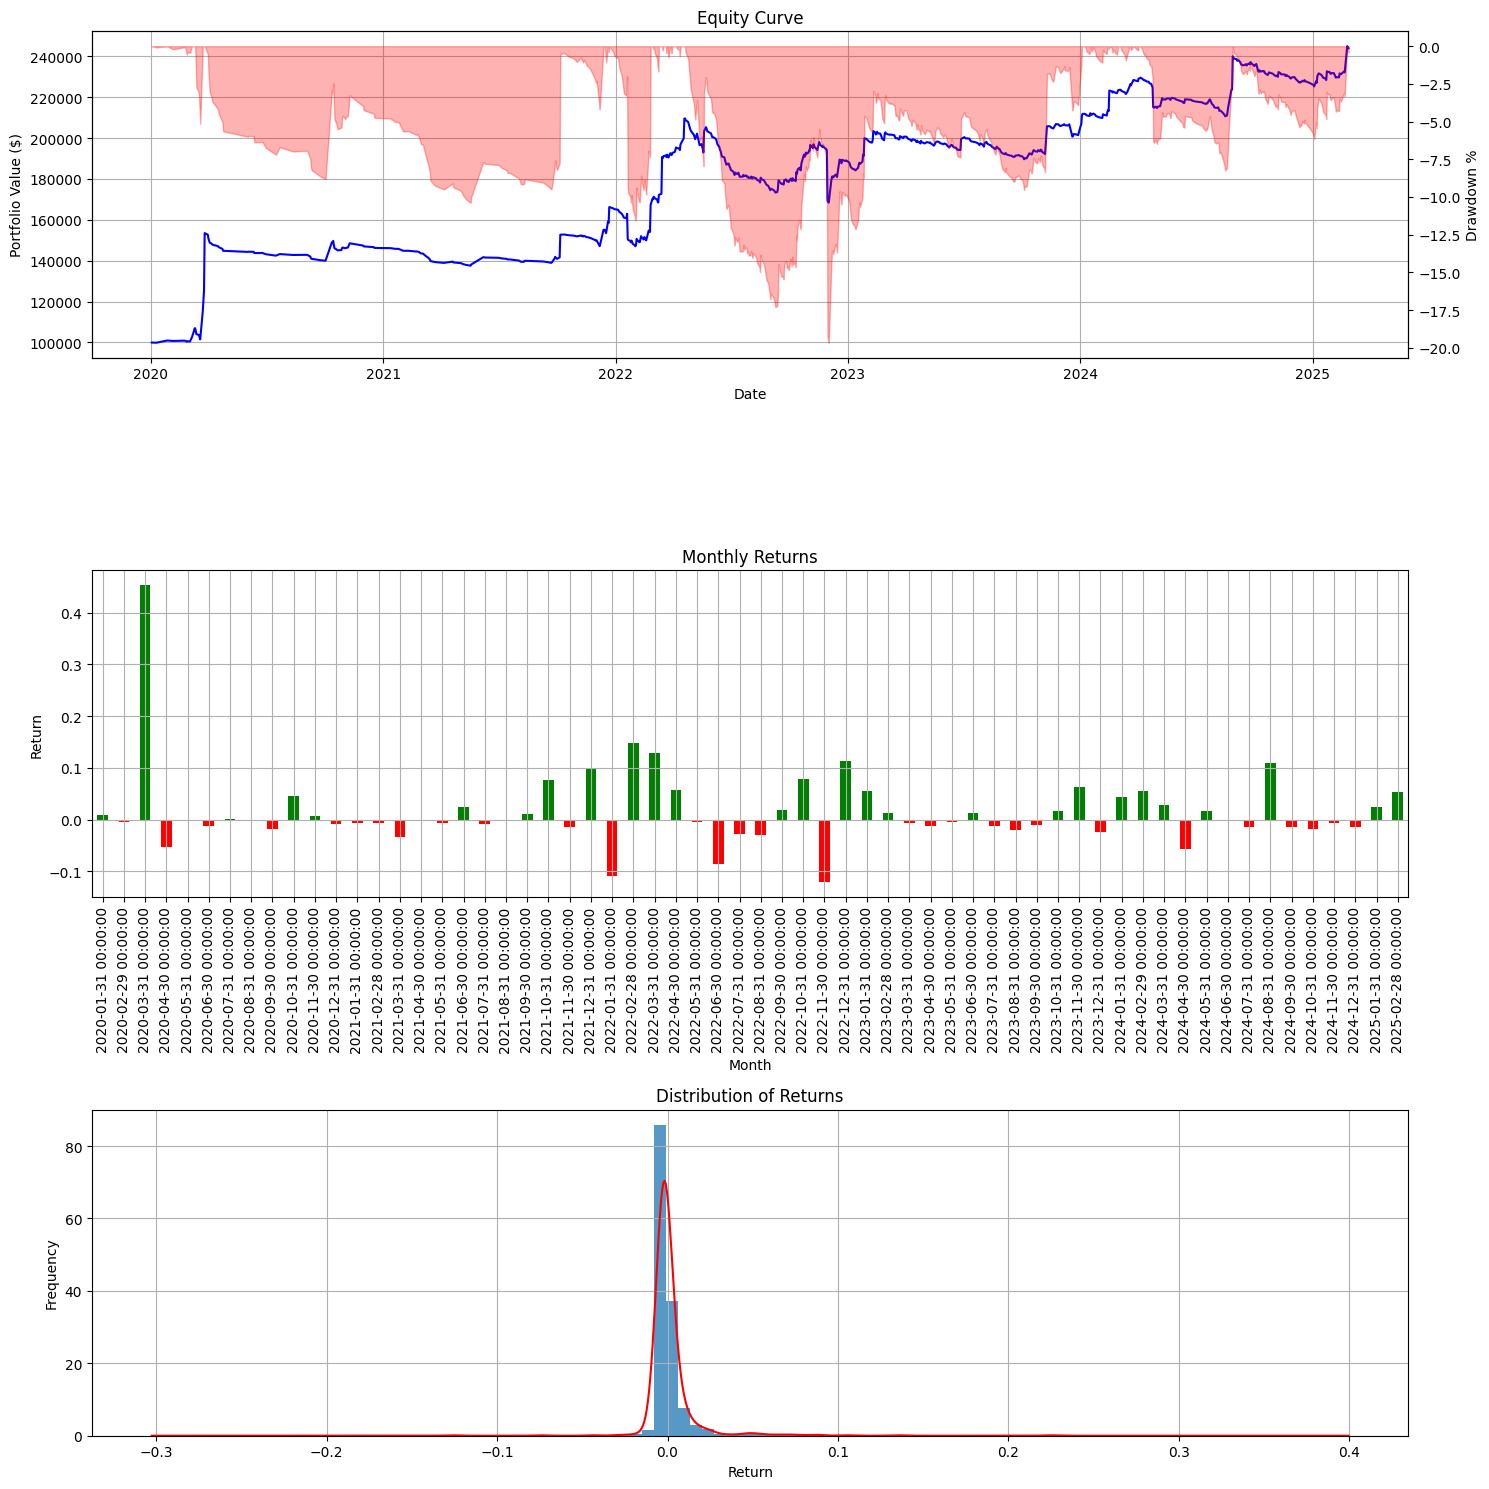

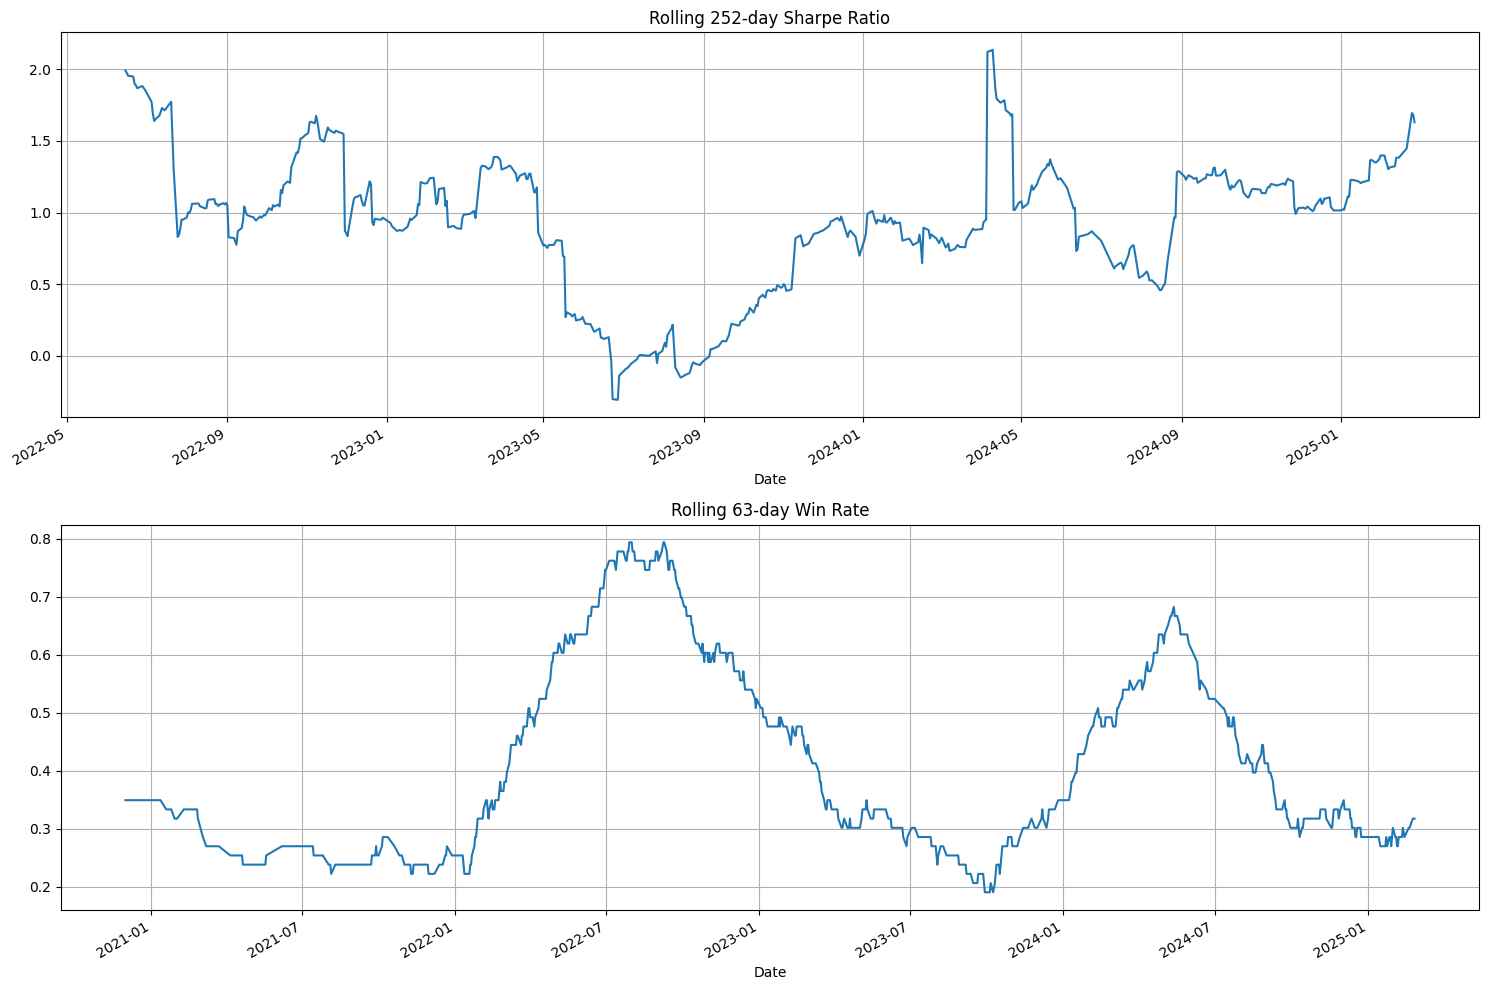

In [184]:
# Test parameters
symbol = 'TQQQ'
start_date = '2020-01-01'
end_date = '2025-02-26'
initial_capital = 100000

# Run backtest
results = backtest_strategy(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
    stop_atr_multiple=0.075,
    min_move_atr_multiple=0.1,
    position_size_risk_pct=0.15,
    transaction_cost_pct=0
)

# Analyze results
analyze_results(results, initial_capital)